## 1. Setup and Configuration

In [2]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Configure Python executable for Spark
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

Python version: 3.11.14 (main, Dec  9 2025, 18:59:10) [MSC v.1944 64 bit (AMD64)]
Python executable: c:\Users\2012m\Desktop\Spark-Kmeans-Scalability\.venv\Scripts\python.exe


## 2. Initialize Spark Session

In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT

# Create Spark session with optimized configuration
spark = SparkSession.builder \
    .appName("Spark-Kmeans-Scalability") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

print(f"✓ Spark {spark.version} session created")
print(f"Master: {spark.sparkContext.master}")
print(f"Default parallelism: {spark.sparkContext.defaultParallelism}")

✓ Spark 3.5.7 session created
Master: local[*]
Default parallelism: 24


## 3. Load GeoTessera Embeddings

In [4]:
from geotessera import GeoTessera

# Initialize GeoTessera client
gt = GeoTessera()

# Define region of interest (bbox)
# Example: Region in Spain
bbox = (-1.671467, 42.804532, -1.599112, 42.838276)  # (min_lon, min_lat, max_lon, max_lat)
year = 2024

print(f"Bounding box: {bbox}")
print(f"Year: {year}")

Could not check for updates: [WinError 183] No se puede crear un archivo que ya existe: 'C:\\Users\\2012m\\AppData\\Local\\geotessera\\.registry.parquet_tmp_aiwq5y_y.parquet' -> 'C:\\Users\\2012m\\AppData\\Local\\geotessera\\registry.parquet'
Could not check for landmasks updates: [WinError 183] No se puede crear un archivo que ya existe: 'C:\\Users\\2012m\\AppData\\Local\\geotessera\\.landmasks.parquet_tmp_3xlp28pg.parquet' -> 'C:\\Users\\2012m\\AppData\\Local\\geotessera\\landmasks.parquet'


Bounding box: (-1.671467, 42.804532, -1.599112, 42.838276)
Year: 2024


In [5]:
# Fetch embeddings for the region
tiles_to_fetch = gt.registry.load_blocks_for_region(bounds=bbox, year=year)
embeddings_gen = gt.fetch_embeddings(tiles_to_fetch)

# Collect all embeddings and metadata
all_embeddings = []
tile_metadata = []

print("Fetching embeddings from GeoTessera...")
for year, tile_lon, tile_lat, embedding_array, crs, transform in embeddings_gen:
    # Flatten spatial dimensions: (H, W, 128) -> (H*W, 128)
    flat_emb = embedding_array.reshape(-1, embedding_array.shape[-1])
    all_embeddings.append(flat_emb)
    
    tile_metadata.append({
        'lat': tile_lat,
        'lon': tile_lon,
        'shape': embedding_array.shape,
        'n_pixels': flat_emb.shape[0],
        'crs': crs,
        'transform': transform
    })
    print(f"  Tile ({tile_lat:.2f}, {tile_lon:.2f}): {embedding_array.shape}")

# Concatenate all embeddings
embeddings_array = np.vstack(all_embeddings)

print(f"\n✓ Total embeddings: {embeddings_array.shape}")
print(f"✓ Number of tiles: {len(tile_metadata)}")
print(f"✓ Total pixels: {embeddings_array.shape[0]:,}")
print(f"✓ Embedding dimension: {embeddings_array.shape[1]}")

Fetching embeddings from GeoTessera...
  Tile (42.85, -1.65): (1124, 835, 128)
  Tile (42.85, -1.55): (1125, 836, 128)

✓ Total embeddings: (1879040, 128)
✓ Number of tiles: 2
✓ Total pixels: 1,879,040
✓ Embedding dimension: 128


## 4. Prepare Data for Spark MLlib

In [6]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# Convert to Pandas DataFrame (much faster than list comprehension)
print("Converting embeddings to Pandas DataFrame...")
pdf = pd.DataFrame(embeddings_array)
pdf['id'] = range(len(pdf))

# Reorder columns to have 'id' first
cols = ['id'] + [col for col in pdf.columns if col != 'id']
pdf = pdf[cols]

print(f"✓ Created Pandas DataFrame with {len(pdf):,} rows")

# Save to Parquet (efficient columnar format)
parquet_path = "embeddings_temp.parquet"
print(f"\nSaving to Parquet: {parquet_path}...")
pdf.to_parquet(parquet_path, engine='pyarrow', index=False)
print(f"✓ Saved to Parquet")

# Read Parquet with Spark
print(f"\nReading Parquet with Spark...")
df_raw = spark.read.parquet(parquet_path)

# Convert columns to a vector using VectorAssembler
feature_cols = [str(i) for i in range(embeddings_array.shape[1])]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df_raw).select("id", "features")

print(f"✓ Created Spark DataFrame with {df.count():,} rows")
df.show(5, truncate=False)

Converting embeddings to Pandas DataFrame...
✓ Created Pandas DataFrame with 1,879,040 rows

Saving to Parquet: embeddings_temp.parquet...
✓ Saved to Parquet

Reading Parquet with Spark...
✓ Created Spark DataFrame with 1,879,040 rows
+---+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 5. Distributed K-means Clustering with Spark

In [7]:
# Configure K-means parameters
k = 4  # Number of clusters
max_iter = 20
seed = 42

print(f"Training Spark K-means with k={k}...")
start_time = time.time()

# Create and train K-means model
kmeans = SparkKMeans(k=k, seed=seed, maxIter=max_iter, featuresCol="features")
model = kmeans.fit(df)

training_time = time.time() - start_time

print(f"\n✓ Training completed in {training_time:.2f} seconds")
print(f"Within Set Sum of Squared Errors (WSSSE): {model.summary.trainingCost:.2f}")

Training Spark K-means with k=4...

✓ Training completed in 33.03 seconds
Within Set Sum of Squared Errors (WSSSE): 540932379.80


In [8]:
# Make predictions
print("Assigning cluster labels...")
predictions = model.transform(df)

# Collect cluster labels
cluster_labels = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
cluster_labels = np.array(cluster_labels)

print(f"✓ Cluster assignment complete")
print(f"\nCluster distribution:")
for i in range(k):
    count = np.sum(cluster_labels == i)
    print(f"  Cluster {i}: {count:,} pixels ({count/len(cluster_labels)*100:.2f}%)")

Assigning cluster labels...
✓ Cluster assignment complete

Cluster distribution:
  Cluster 0: 365,124 pixels (19.43%)
  Cluster 1: 584,230 pixels (31.09%)
  Cluster 2: 628,524 pixels (33.45%)
  Cluster 3: 301,162 pixels (16.03%)


## 6. Scalability Analysis

In [9]:
# Test scalability with different data sizes
sample_sizes = [0.1, 0.25, 0.5, 0.75, 1.0]  # Fractions of total data
training_times = []
wssse_values = []
data_points = []

print("Running scalability analysis...\n")

for fraction in sample_sizes:
    # Sample data
    sample_df = df.sample(fraction=fraction, seed=seed)
    n_samples = sample_df.count()
    data_points.append(n_samples)
    
    # Train K-means
    start = time.time()
    sample_model = kmeans.fit(sample_df)
    elapsed = time.time() - start
    
    training_times.append(elapsed)
    wssse_values.append(sample_model.summary.trainingCost)
    
    print(f"Fraction: {fraction:.2f} | Samples: {n_samples:,} | Time: {elapsed:.2f}s | WSSSE: {sample_model.summary.trainingCost:.2f}")

print("\n✓ Scalability analysis complete")

Running scalability analysis...

Fraction: 0.10 | Samples: 188,908 | Time: 17.68s | WSSSE: 54253464.91
Fraction: 0.25 | Samples: 470,651 | Time: 19.95s | WSSSE: 135264180.61
Fraction: 0.50 | Samples: 940,998 | Time: 23.36s | WSSSE: 270715502.05
Fraction: 0.75 | Samples: 1,410,380 | Time: 26.47s | WSSSE: 405955769.83
Fraction: 1.00 | Samples: 1,879,040 | Time: 30.51s | WSSSE: 540932379.80

✓ Scalability analysis complete


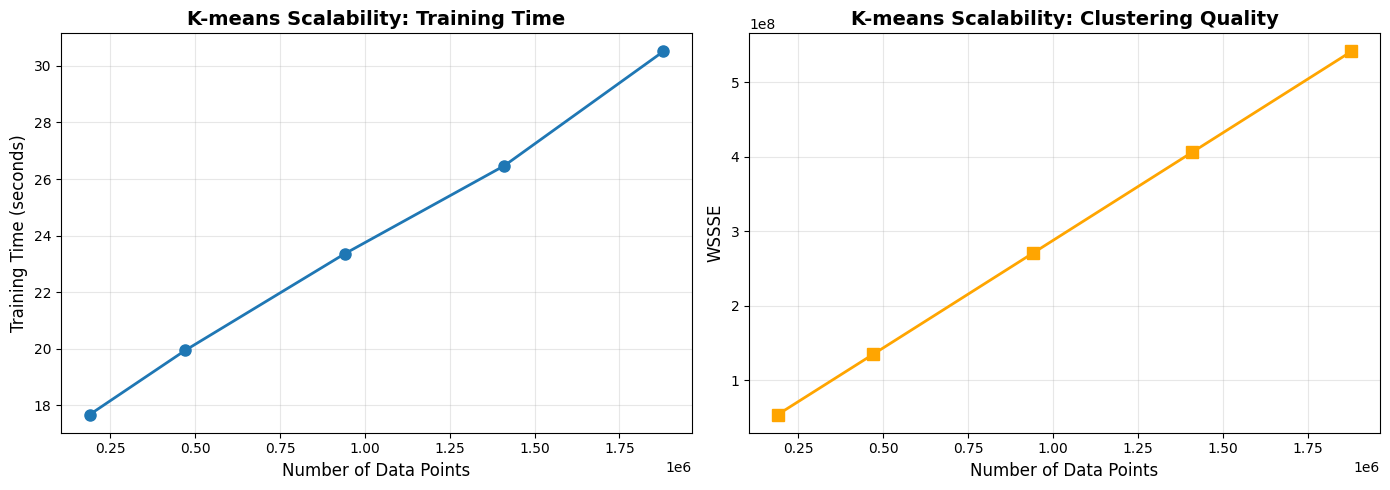

In [10]:
# Visualize scalability results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training time vs data size
axes[0].plot(data_points, training_times, 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Data Points', fontsize=12)
axes[0].set_ylabel('Training Time (seconds)', fontsize=12)
axes[0].set_title('K-means Scalability: Training Time', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: WSSSE vs data size
axes[1].plot(data_points, wssse_values, 's-', color='orange', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Data Points', fontsize=12)
axes[1].set_ylabel('WSSSE', fontsize=12)
axes[1].set_title('K-means Scalability: Clustering Quality', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Visualize Clustering Results

Performing PCA for visualization...


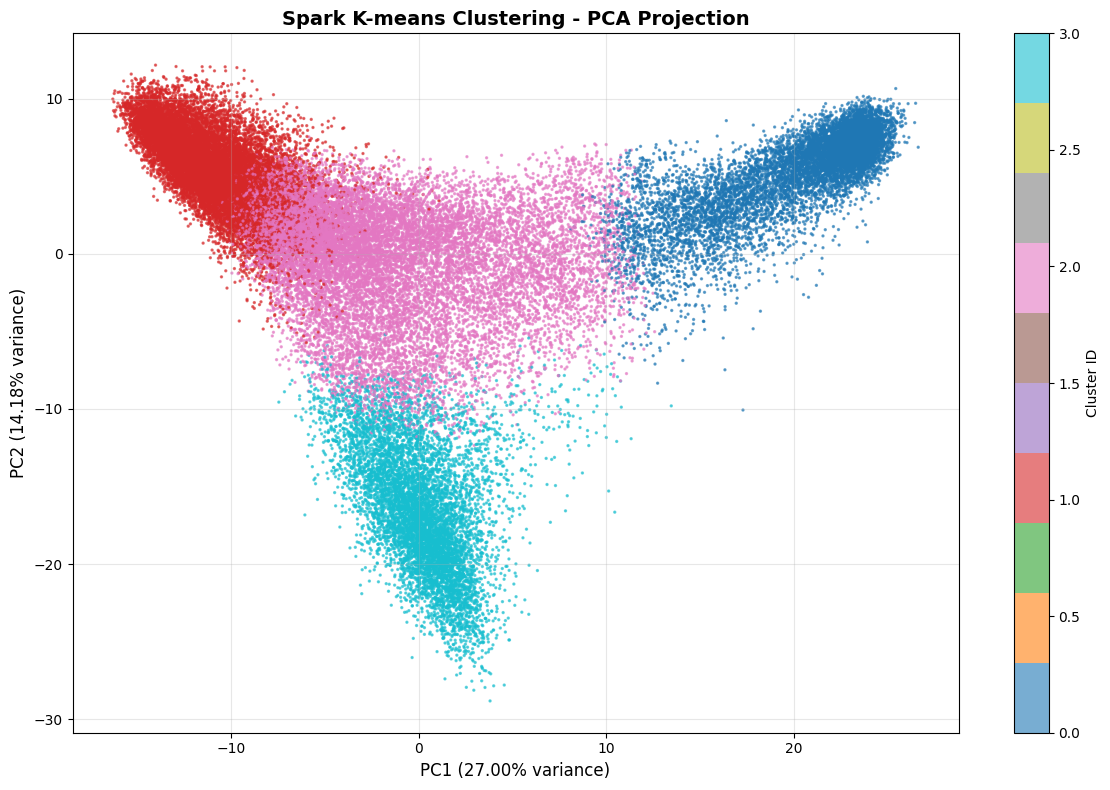

Total variance explained: 41.17%


In [11]:
# PCA projection for visualization
print("Performing PCA for visualization...")
pca = PCA(n_components=2)

# Sample if too many points
max_viz_points = 50000
if len(embeddings_array) > max_viz_points:
    sample_idx = np.random.choice(len(embeddings_array), max_viz_points, replace=False)
    viz_embeddings = embeddings_array[sample_idx]
    viz_labels = cluster_labels[sample_idx]
else:
    viz_embeddings = embeddings_array
    viz_labels = cluster_labels

embeddings_2d = pca.fit_transform(viz_embeddings)

# Plot PCA projection
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                     c=viz_labels, cmap='tab10', alpha=0.6, s=2)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('Spark K-means Clustering - PCA Projection', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2%}")

## 7a. Cluster Centroids Analysis

Visualize cluster centroids and their distances to understand cluster separation.

In [12]:
# Extract cluster centroids from the K-means model
centroids = np.array([center for center in model.clusterCenters()])

print(f"Cluster centroids shape: {centroids.shape}")
print(f"Number of centroids: {centroids.shape[0]}")
print(f"Centroid dimension: {centroids.shape[1]}")

Cluster centroids shape: (4, 128)
Number of centroids: 4
Centroid dimension: 128


In [13]:
# Calculate pairwise distances between centroids
from scipy.spatial.distance import pdist, squareform

# Compute Euclidean distances between all pairs of centroids
distances = squareform(pdist(centroids, metric='euclidean'))

print("\nPairwise distances between cluster centroids:")
print("="*60)
for i in range(k):
    for j in range(i+1, k):
        print(f"  Cluster {i} ↔ Cluster {j}: {distances[i, j]:.4f}")

print(f"\nAverage inter-cluster distance: {np.mean(distances[np.triu_indices_from(distances, k=1)]):.4f}")
print(f"Min inter-cluster distance: {np.min(distances[np.nonzero(distances)]):.4f}")
print(f"Max inter-cluster distance: {np.max(distances):.4f}")


Pairwise distances between cluster centroids:
  Cluster 0 ↔ Cluster 1: 31.1401
  Cluster 0 ↔ Cluster 2: 24.0781
  Cluster 0 ↔ Cluster 3: 29.5046
  Cluster 1 ↔ Cluster 2: 15.0602
  Cluster 1 ↔ Cluster 3: 24.7326
  Cluster 2 ↔ Cluster 3: 19.2112

Average inter-cluster distance: 23.9545
Min inter-cluster distance: 15.0602
Max inter-cluster distance: 31.1401


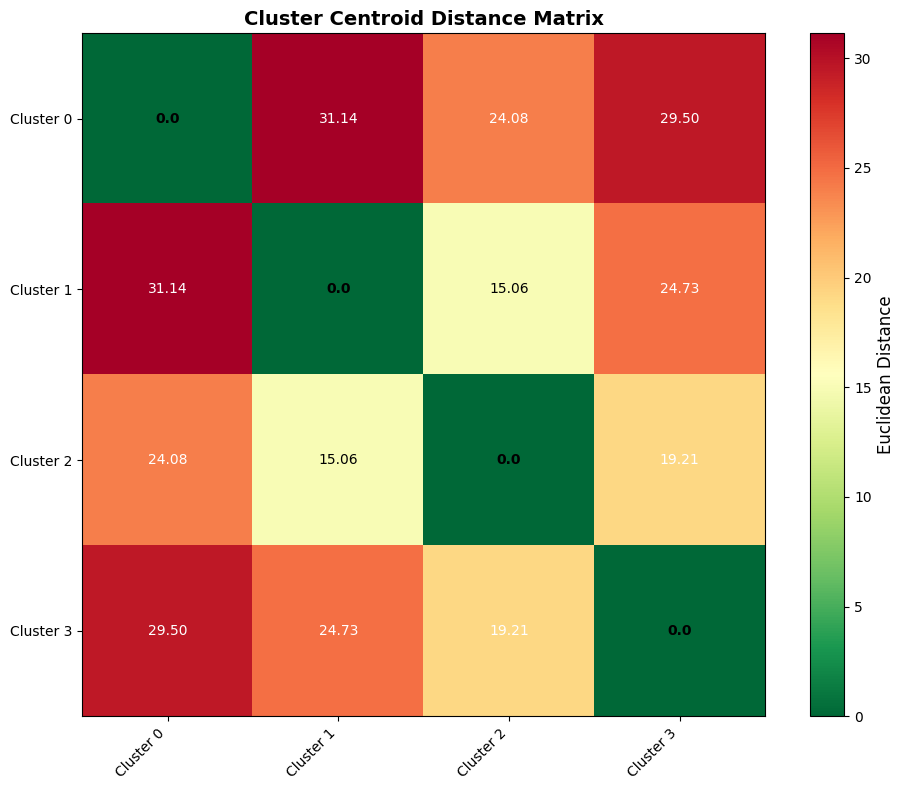

✓ Distance matrix visualization complete


In [14]:
# Visualize centroid distance matrix as heatmap
fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(distances, cmap='RdYlGn_r', interpolation='nearest')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Euclidean Distance', fontsize=12)

# Add text annotations
for i in range(k):
    for j in range(k):
        if i == j:
            text = ax.text(j, i, '0.0', ha='center', va='center', 
                         color='black', fontsize=10, fontweight='bold')
        else:
            text = ax.text(j, i, f'{distances[i, j]:.2f}', ha='center', va='center',
                         color='white' if distances[i, j] > distances.max()/2 else 'black',
                         fontsize=10)

ax.set_xticks(range(k))
ax.set_yticks(range(k))
ax.set_xticklabels([f'Cluster {i}' for i in range(k)])
ax.set_yticklabels([f'Cluster {i}' for i in range(k)])
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_title('Cluster Centroid Distance Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Distance matrix visualization complete")

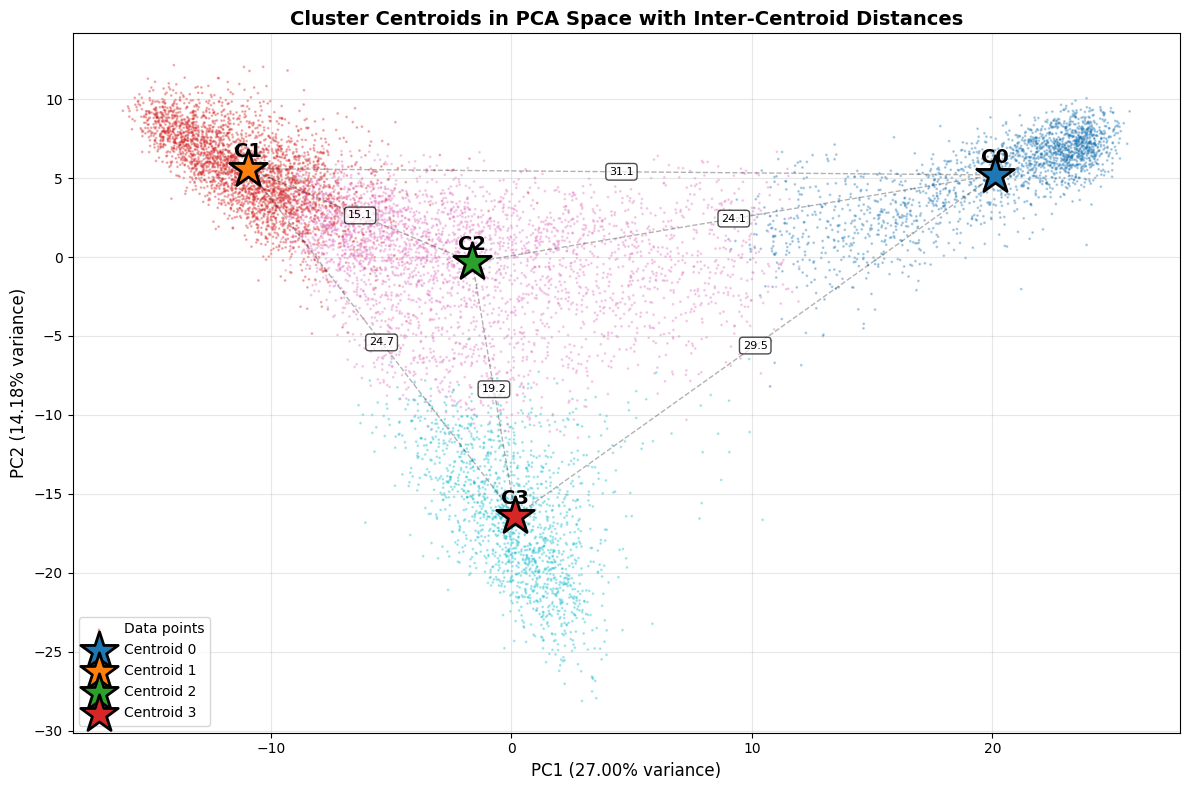

✓ Centroid visualization in 2D PCA space complete


In [15]:
# Project centroids to 2D using PCA for visualization
centroids_2d = pca.transform(centroids)

# Create visualization of centroids in 2D space
fig, ax = plt.subplots(figsize=(12, 8))

# Plot data points (sample)
if len(embeddings_2d) > 10000:
    sample_idx = np.random.choice(len(embeddings_2d), 10000, replace=False)
    ax.scatter(embeddings_2d[sample_idx, 0], embeddings_2d[sample_idx, 1],
              c=viz_labels[sample_idx], cmap='tab10', alpha=0.3, s=1, label='Data points')
else:
    ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
              c=viz_labels, cmap='tab10', alpha=0.3, s=1, label='Data points')

# Plot centroids as large markers
colors = plt.cm.tab10(np.arange(k))
for i in range(k):
    ax.scatter(centroids_2d[i, 0], centroids_2d[i, 1], 
              marker='*', s=800, c=[colors[i]], edgecolors='black', 
              linewidths=2, label=f'Centroid {i}', zorder=10)
    
    # Add labels
    ax.text(centroids_2d[i, 0], centroids_2d[i, 1] + 0.5, f'C{i}',
           fontsize=14, fontweight='bold', ha='center', va='bottom')

# Draw lines between centroids showing distances
for i in range(k):
    for j in range(i+1, k):
        ax.plot([centroids_2d[i, 0], centroids_2d[j, 0]], 
               [centroids_2d[i, 1], centroids_2d[j, 1]],
               'k--', alpha=0.3, linewidth=1)
        
        # Add distance label at midpoint
        mid_x = (centroids_2d[i, 0] + centroids_2d[j, 0]) / 2
        mid_y = (centroids_2d[i, 1] + centroids_2d[j, 1]) / 2
        ax.text(mid_x, mid_y, f'{distances[i, j]:.1f}',
               fontsize=8, ha='center', va='center',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
ax.set_title('Cluster Centroids in PCA Space with Inter-Centroid Distances', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()

print("✓ Centroid visualization in 2D PCA space complete")

In [16]:
# Calculate within-cluster variance for each cluster
within_cluster_variances = []

print("\nWithin-cluster variance (compactness):")
print("="*60)

for cluster_id in range(k):
    cluster_mask = cluster_labels == cluster_id
    cluster_points = embeddings_array[cluster_mask]
    
    # Calculate variance as average squared distance to centroid
    centroid = centroids[cluster_id]
    squared_distances = np.sum((cluster_points - centroid) ** 2, axis=1)
    variance = np.mean(squared_distances)
    
    within_cluster_variances.append(variance)
    print(f"  Cluster {cluster_id}: {variance:.4f} (n={np.sum(cluster_mask):,} points)")

print(f"\nAverage within-cluster variance: {np.mean(within_cluster_variances):.4f}")
print(f"\nCluster quality metrics:")
print(f"  - Tight clusters have LOW within-cluster variance")
print(f"  - Well-separated clusters have HIGH inter-cluster distances")


Within-cluster variance (compactness):
  Cluster 0: 243.5773 (n=365,124 points)
  Cluster 1: 198.9485 (n=584,230 points)
  Cluster 2: 360.1890 (n=628,524 points)
  Cluster 3: 363.1845 (n=301,162 points)

Average within-cluster variance: 291.4748

Cluster quality metrics:
  - Tight clusters have LOW within-cluster variance
  - Well-separated clusters have HIGH inter-cluster distances


## 7b. Georeferenced Maps of Clusters and Classes

Visualize the spatial distribution of clusters and interpretable classes on a geographic map.

In [17]:
from rasterio.transform import from_bounds

# Reconstruct cluster maps for each tile
print("Reconstructing spatial maps for each tile...")

tile_maps = []
start_idx = 0

for idx, tile in enumerate(tile_metadata):
    n_pixels = tile['n_pixels']
    
    # Extract labels for this tile
    tile_cluster_labels = cluster_labels[start_idx:start_idx + n_pixels]
    
    # Reshape back to spatial dimensions
    h, w = tile['shape'][0], tile['shape'][1]
    tile_cluster_map = tile_cluster_labels.reshape(h, w)
    
    tile_maps.append({
        'cluster_map': tile_cluster_map,
        'lat': tile['lat'],
        'lon': tile['lon'],
        'crs': tile['crs'],
        'transform': tile['transform'],
        'shape': tile['shape']
    })
    
    start_idx += n_pixels

print(f"✓ Created spatial maps for {len(tile_maps)} tiles")
print(f"Total pixels processed: {start_idx:,}")

Reconstructing spatial maps for each tile...
✓ Created spatial maps for 2 tiles
Total pixels processed: 1,879,040


In [18]:
# Calculate global bounds for all tiles
all_bounds = []
for tile in tile_maps:
    t = tile['transform']
    h, w = tile['shape'][0], tile['shape'][1]
    
    # Calculate tile bounds
    min_x = t.c
    max_y = t.f
    max_x = min_x + w * t.a
    min_y = max_y + h * t.e  # e is negative
    
    all_bounds.append((min_x, min_y, max_x, max_y))

# Global bounding box
min_x = min(b[0] for b in all_bounds)
min_y = min(b[1] for b in all_bounds)
max_x = max(b[2] for b in all_bounds)
max_y = max(b[3] for b in all_bounds)

print(f"Global bounds: ({min_x:.6f}, {min_y:.6f}, {max_x:.6f}, {max_y:.6f})")

# Use resolution from first tile
first_transform = tile_maps[0]['transform']
pixel_size_x = first_transform.a
pixel_size_y = -first_transform.e

width = int((max_x - min_x) / pixel_size_x)
height = int((max_y - min_y) / pixel_size_y)

print(f"Mosaic dimensions: {width} x {height} pixels")
print(f"Pixel size: {pixel_size_x:.6f} x {pixel_size_y:.6f}")

# Create output transform
output_transform = from_bounds(min_x, min_y, max_x, max_y, width, height)

# Initialize mosaic with -1 (no data)
cluster_mosaic = np.full((height, width), -1, dtype=np.int32)

print(f"✓ Created empty mosaic of shape {cluster_mosaic.shape}")

Global bounds: (606133.215021, 4739420.725289, 622657.426022, 4750801.402397)
Mosaic dimensions: 1652 x 1138 pixels
Pixel size: 10.000000 x 10.000000
✓ Created empty mosaic of shape (1138, 1652)


In [19]:
# Place each tile in the mosaic
print("\nAssembling mosaic...")
for idx, tile in enumerate(tile_maps):
    cluster_map = tile['cluster_map'].astype(np.int32)
    tile_transform = tile['transform']
    
    # Calculate pixel offset in the mosaic
    tile_min_x = tile_transform.c
    tile_max_y = tile_transform.f
    
    col_offset = int((tile_min_x - min_x) / pixel_size_x)
    row_offset = int((max_y - tile_max_y) / pixel_size_y)
    
    tile_height, tile_width = cluster_map.shape
    
    # Place the tile in the mosaic
    cluster_mosaic[row_offset:row_offset+tile_height, col_offset:col_offset+tile_width] = cluster_map
    
    print(f"  Placed tile {idx} at offset ({row_offset}, {col_offset})")

print(f"\n✓ K-means cluster mosaic assembly complete!")


Assembling mosaic...
  Placed tile 0 at offset (14, 0)
  Placed tile 1 at offset (0, 816)

✓ K-means cluster mosaic assembly complete!


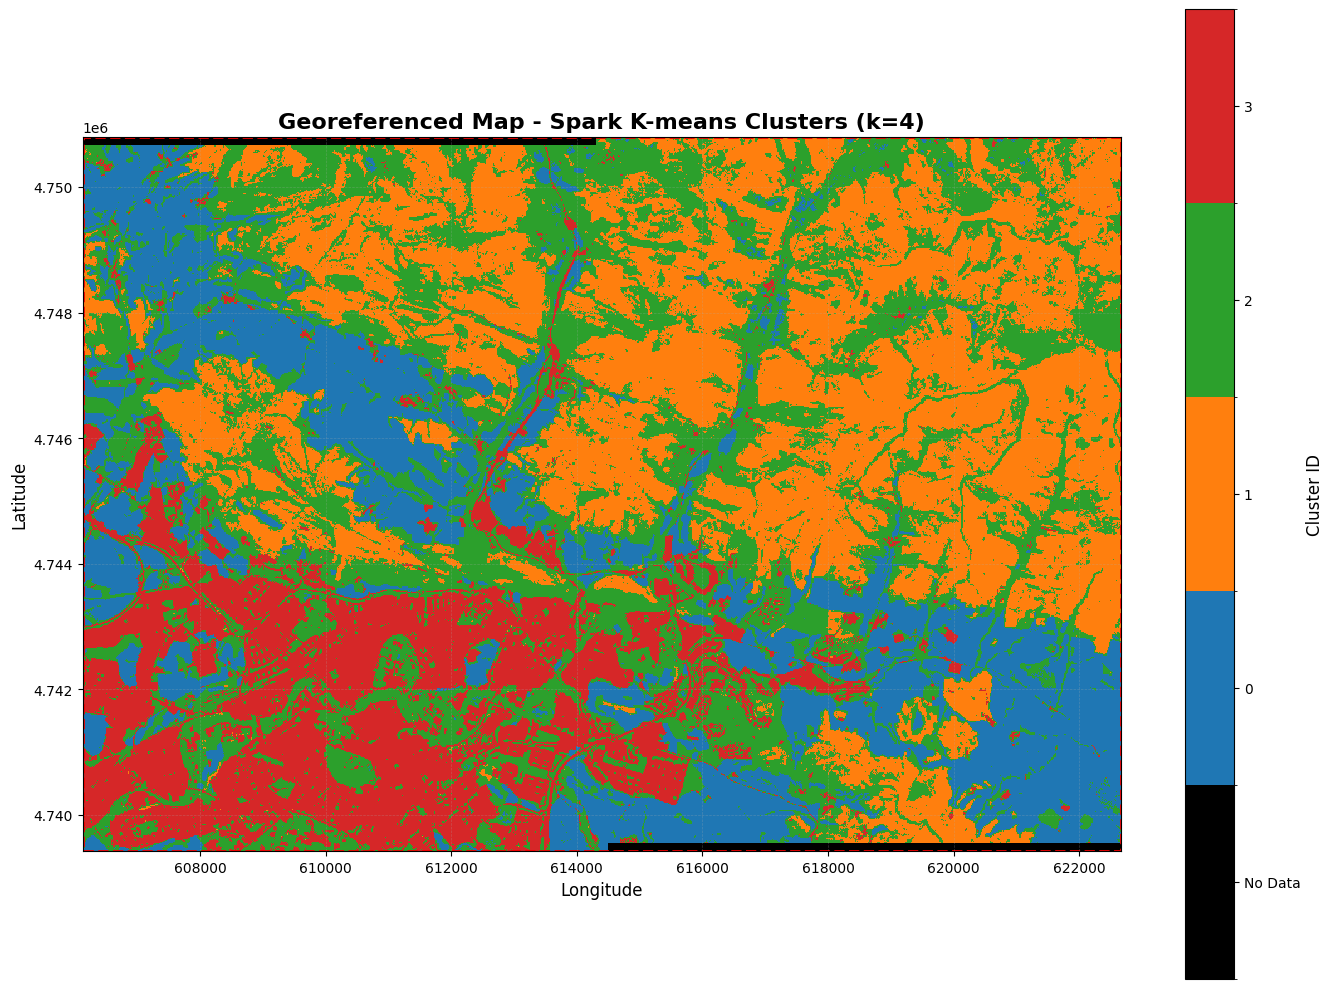

✓ K-means cluster map displayed!
CRS: EPSG:32630
Bounding box: (-1.671467, 42.804532, -1.599112, 42.838276)


In [20]:
# Visualize the K-means cluster mosaic
# Create custom colormap with black for no data
cmap_clusters = plt.cm.tab10.copy()
colors_list = [cmap_clusters(i) for i in range(k)]
colors_list.insert(0, (0, 0, 0, 1))  # Black for no-data (-1)

custom_cmap = mcolors.ListedColormap(colors_list)
bounds = list(range(-1, k + 1))
norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(14, 10))

im = ax.imshow(cluster_mosaic, cmap=custom_cmap, norm=norm, interpolation='nearest',
               extent=[min_x, max_x, min_y, max_y])

ax.set_title(f'Georeferenced Map - Spark K-means Clusters (k={k})', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Colorbar
cbar = plt.colorbar(im, ax=ax, ticks=np.arange(-0.5, k, 1))
cbar.set_label('Cluster ID', fontsize=12)
cbar.ax.set_yticklabels(['No Data'] + [str(i) for i in range(k)])

# Grid and bbox outline
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

from matplotlib.patches import Rectangle
rect = Rectangle((min_x, min_y), max_x - min_x, max_y - min_y,
                 linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
ax.add_patch(rect)

plt.tight_layout()
plt.show()

print(f"✓ K-means cluster map displayed!")
print(f"CRS: {tile_maps[0]['crs']}")
print(f"Bounding box: {bbox}")

## 8. Create Labeled Training Data for KNN

Simulate hand-labeled data based on cluster centroids and domain knowledge

In [21]:
# Define interpretable classes
class_names = {
    0: 'Vegetation',
    1: 'Urban',
    2: 'Agricultural',
    3: 'Mixed/Infrastructure'
}

# Define labeled training points using specific GPS coordinates
labeled_points = {
    'Urban': (42.81705646247483, -1.643587157025676),
    'Agricultural': (42.8025062515429, -1.5902235915622889),  
    'Vegetation': (42.85225976609662, -1.672211490365638)
}

print("Labeled training points:")
for class_name, (lat, lon) in labeled_points.items():
    print(f"  {class_name}: ({lat:.6f}, {lon:.6f})")

# Function to find pixel index from GPS coordinates
def find_pixel_from_gps(lat, lon, tile_metadata):
    """Find the pixel index corresponding to GPS coordinates.
    
    Converts GPS coordinates (lat/lon in EPSG:4326) to the tile's CRS before searching.
    """
    from pyproj import Transformer
    
    cumulative_idx = 0
    
    # Get CRS from first tile
    tile_crs = tile_metadata[0]['crs']
    
    # Create transformer from WGS84 (EPSG:4326) to tile CRS
    # Note: pyproj expects (lat, lon) order for EPSG:4326
    transformer = Transformer.from_crs("EPSG:4326", tile_crs, always_xy=False)
    
    # Transform GPS coordinates to tile CRS
    # transformer expects (lat, lon) for geographic CRS
    x_proj, y_proj = transformer.transform(lat, lon)
    
    print(f"  GPS ({lat:.6f}, {lon:.6f}) → Projected ({x_proj:.2f}, {y_proj:.2f}) in {tile_crs}")
    
    for tile in tile_metadata:
        t = tile['transform']
        h, w = tile['shape'][0], tile['shape'][1]
        
        # Calculate tile bounds in projected coordinates
        min_x = t.c
        max_y = t.f
        max_x = min_x + w * t.a
        min_y = max_y + h * t.e  # e is negative
        
        # Check if projected point is within this tile
        if min_x <= x_proj <= max_x and min_y <= y_proj <= max_y:
            # Calculate pixel position within tile
            col = int((x_proj - min_x) / t.a)
            row = int((y_proj - max_y) / t.e)  # e is negative
            
            # Ensure within bounds
            col = max(0, min(col, w - 1))
            row = max(0, min(row, h - 1))
            
            # Calculate absolute pixel index
            pixel_idx = cumulative_idx + row * w + col
            return pixel_idx, tile, row, col
        
        cumulative_idx += tile['n_pixels']
    
    return None, None, None, None

# Create labeled dataset based on cluster assignments from GPS points
class_to_id = {'Vegetation': 0, 'Urban': 1, 'Agricultural': 2, 'Mixed/Infrastructure': 3}

# Step 1: Map GPS points to their clusters
cluster_to_class = {}

print("\nMapping GPS points to K-means clusters:")
for class_name, (lat, lon) in labeled_points.items():
    pixel_idx, tile, row, col = find_pixel_from_gps(lat, lon, tile_metadata)
    
    if pixel_idx is not None:
        # Get the cluster assignment for this pixel
        cluster_id = cluster_labels[pixel_idx]
        cluster_to_class[cluster_id] = class_to_id[class_name]
        
        print(f"  {class_name}: pixel {pixel_idx} → Cluster {cluster_id}")
        print(f"    Location: (tile lat={tile['lat']:.2f}, lon={tile['lon']:.2f}, row={row}, col={col})")
    else:
        print(f"  {class_name}: WARNING - coordinates not found in tiles!")

# Step 2: Assign remaining clusters to "Mixed/Infrastructure"
mixed_class_id = 3
used_clusters = set(cluster_to_class.keys())

for cluster_id in range(k):
    if cluster_id not in used_clusters:
        cluster_to_class[cluster_id] = mixed_class_id

print(f"\nCluster to Class mapping:")
for cluster_id in range(k):
    class_id = cluster_to_class[cluster_id]
    class_name = [name for cid, name in class_names.items() if cid == class_id][0]
    cluster_size = np.sum(cluster_labels == cluster_id)
    print(f"  Cluster {cluster_id} → {class_name} ({cluster_size:,} pixels)")

# Step 3: Create training data by sampling from each cluster
np.random.seed(seed)
samples_per_cluster = 2000  # Sample 2000 pixels from each cluster for KNN training

labeled_indices = []
y_labeled = []

print(f"\nSampling {samples_per_cluster} pixels from each cluster for KNN training:")
for cluster_id in range(k):
    # Find all pixels in this cluster
    cluster_mask = cluster_labels == cluster_id
    cluster_pixel_indices = np.where(cluster_mask)[0]
    
    # Get the class for this cluster
    class_id = cluster_to_class[cluster_id]
    
    # Sample a subset for training
    n_samples = min(samples_per_cluster, len(cluster_pixel_indices))
    sampled_indices = np.random.choice(cluster_pixel_indices, n_samples, replace=False)
    
    # Add them to labeled dataset
    labeled_indices.extend(sampled_indices.tolist())
    y_labeled.extend([class_id] * len(sampled_indices))
    
    class_name = [name for cid, name in class_names.items() if cid == class_id][0]
    print(f"  Cluster {cluster_id} ({class_name}): sampled {n_samples:,} pixels")

labeled_indices = np.array(labeled_indices)
y_labeled = np.array(y_labeled)

X_labeled = embeddings_array[labeled_indices]

n_labeled_samples = len(labeled_indices)
print(f"\n✓ Created labeled dataset:")
print(f"  Total labeled samples: {n_labeled_samples}")
print(f"  Features shape: {X_labeled.shape}")
print(f"\nClass distribution:")
for class_id, class_name in class_names.items():
    count = np.sum(y_labeled == class_id)
    print(f"  {class_id} - {class_name}: {count} samples")

Labeled training points:
  Urban: (42.817056, -1.643587)
  Agricultural: (42.802506, -1.590224)
  Vegetation: (42.852260, -1.672211)

Mapping GPS points to K-means clusters:
  GPS (42.817056, -1.643587) → Projected (610887.22, 4741391.74) in EPSG:32630
  Urban: pixel 773685 → Cluster 3
    Location: (tile lat=42.85, lon=-1.65, row=926, col=475)
  GPS (42.802506, -1.590224) → Projected (615276.80, 4739847.57) in EPSG:32630
  Agricultural: pixel 1854057 → Cluster 0
    Location: (tile lat=42.85, lon=-1.55, row=1095, col=97)
  GPS (42.852260, -1.672211) → Projected (608485.53, 4745263.71) in EPSG:32630
  Vegetation: pixel 450300 → Cluster 2
    Location: (tile lat=42.85, lon=-1.65, row=539, col=235)

Cluster to Class mapping:
  Cluster 0 → Agricultural (365,124 pixels)
  Cluster 1 → Mixed/Infrastructure (584,230 pixels)
  Cluster 2 → Vegetation (628,524 pixels)
  Cluster 3 → Urban (301,162 pixels)

Sampling 2000 pixels from each cluster for KNN training:
  Cluster 0 (Agricultural): sample

## 9. Train KNN Classifier for Interpretability

In [22]:
from sklearn.model_selection import train_test_split

# Split labeled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_labeled, y_labeled, test_size=0.3, random_state=seed, stratify=y_labeled
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Train KNN classifier
print("\nTraining KNN classifier...")
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train, y_train)

# Evaluate on test set
y_pred = knn.predict(X_test)
accuracy = np.mean(y_pred == y_test)

print(f"\n✓ KNN training complete")
print(f"Test accuracy: {accuracy:.2%}")

Training set: 5600 samples
Test set: 2400 samples

Training KNN classifier...

✓ KNN training complete
Test accuracy: 95.71%


In [23]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=list(class_names.values())))


Classification Report:
                      precision    recall  f1-score   support

          Vegetation       0.96      0.87      0.91       600
               Urban       0.96      0.99      0.98       600
        Agricultural       0.97      0.99      0.98       600
Mixed/Infrastructure       0.94      0.98      0.96       600

            accuracy                           0.96      2400
           macro avg       0.96      0.96      0.96      2400
        weighted avg       0.96      0.96      0.96      2400



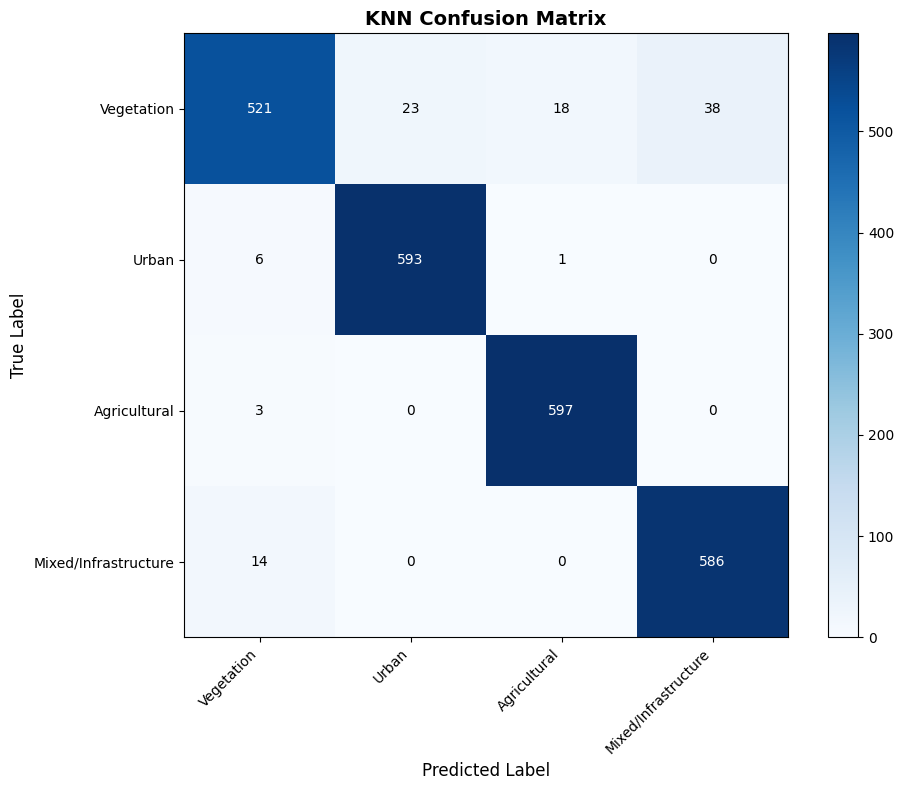

In [24]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
im = plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar(im)

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center',
                color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.xticks(range(len(class_names)), list(class_names.values()), rotation=45, ha='right')
plt.yticks(range(len(class_names)), list(class_names.values()))
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('KNN Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Compare K-means and KNN Results

In [25]:
# Predict interpretable classes for all embeddings using KNN
print("Predicting interpretable labels for all embeddings...")
knn_labels_all = knn.predict(embeddings_array)

print(f"\nKNN Class distribution (all data):")
for class_id, class_name in class_names.items():
    count = np.sum(knn_labels_all == class_id)
    print(f"  {class_id} - {class_name}: {count:,} pixels ({count/len(knn_labels_all)*100:.2f}%)")

Predicting interpretable labels for all embeddings...

KNN Class distribution (all data):
  0 - Vegetation: 565,626 pixels (30.10%)
  1 - Urban: 319,061 pixels (16.98%)
  2 - Agricultural: 377,787 pixels (20.11%)
  3 - Mixed/Infrastructure: 616,566 pixels (32.81%)


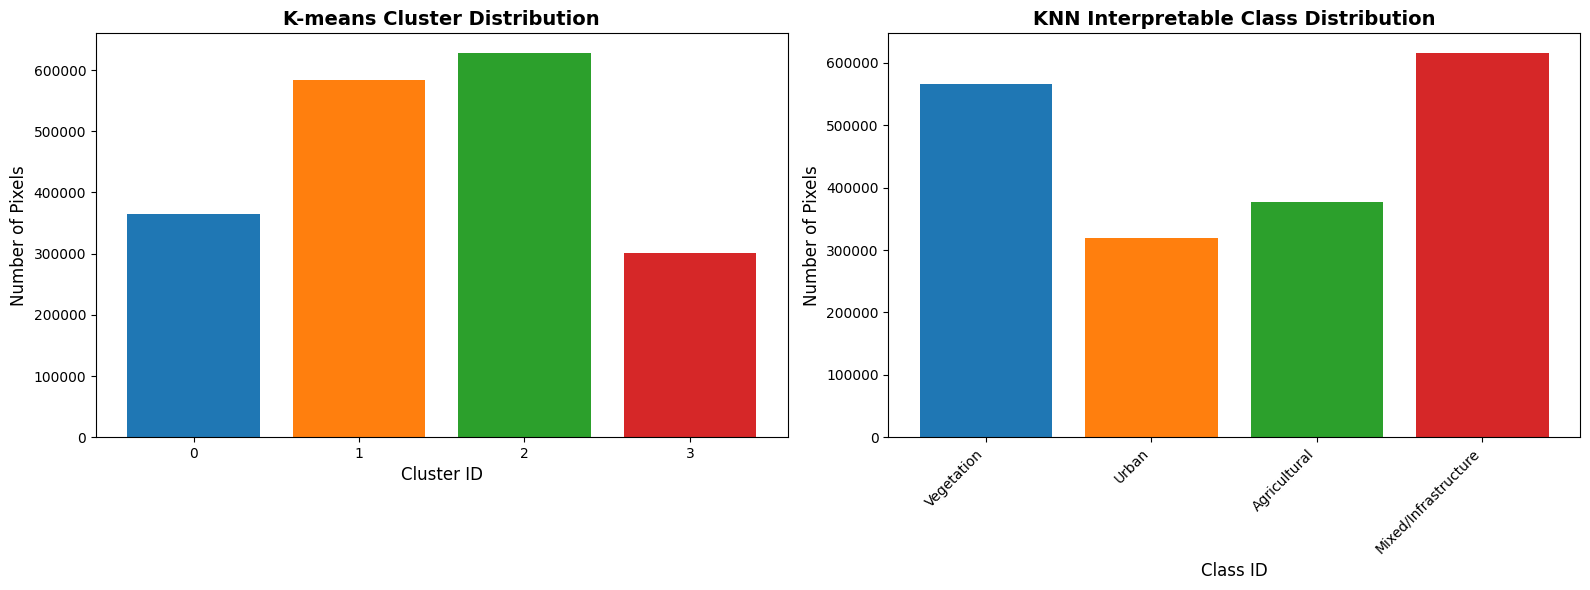

In [26]:
# Compare cluster and class distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# K-means cluster distribution
cluster_counts = np.bincount(cluster_labels, minlength=k)
axes[0].bar(range(k), cluster_counts, color=plt.cm.tab10(np.arange(k)))
axes[0].set_xlabel('Cluster ID', fontsize=12)
axes[0].set_ylabel('Number of Pixels', fontsize=12)
axes[0].set_title('K-means Cluster Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(k))

# KNN class distribution
class_counts = np.bincount(knn_labels_all, minlength=len(class_names))
axes[1].bar(range(len(class_names)), class_counts, color=plt.cm.tab10(np.arange(len(class_names))))
axes[1].set_xlabel('Class ID', fontsize=12)
axes[1].set_ylabel('Number of Pixels', fontsize=12)
axes[1].set_title('KNN Interpretable Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(class_names)))
axes[1].set_xticklabels([class_names[i] for i in range(len(class_names))], rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [27]:
# Cross-tabulation: How do K-means clusters map to interpretable classes?
print("\nCross-tabulation: K-means Clusters vs KNN Classes")
print("="*80)

crosstab = np.zeros((k, len(class_names)), dtype=int)
for cluster_id in range(k):
    cluster_mask = cluster_labels == cluster_id
    cluster_knn_labels = knn_labels_all[cluster_mask]
    
    for class_id in range(len(class_names)):
        crosstab[cluster_id, class_id] = np.sum(cluster_knn_labels == class_id)

# Display as DataFrame for better readability
import pandas as pd
crosstab_df = pd.DataFrame(crosstab, 
                          columns=[class_names[i] for i in range(len(class_names))],
                          index=[f'Cluster {i}' for i in range(k)])
print(crosstab_df)

# Find dominant class for each cluster
print("\nDominant interpretable class per K-means cluster:")
for cluster_id in range(k):
    dominant_class = np.argmax(crosstab[cluster_id])
    dominant_count = crosstab[cluster_id, dominant_class]
    total_count = np.sum(crosstab[cluster_id])
    print(f"  Cluster {cluster_id} → {class_names[dominant_class]} "
          f"({dominant_count:,}/{total_count:,} = {dominant_count/total_count*100:.1f}%)")


Cross-tabulation: K-means Clusters vs KNN Classes
           Vegetation   Urban  Agricultural  Mixed/Infrastructure
Cluster 0        2911     191        362022                     0
Cluster 1       12230     152             0                571848
Cluster 2      546581   21890         15471                 44582
Cluster 3        3904  296828           294                   136

Dominant interpretable class per K-means cluster:
  Cluster 0 → Agricultural (362,022/365,124 = 99.2%)
  Cluster 1 → Mixed/Infrastructure (571,848/584,230 = 97.9%)
  Cluster 2 → Vegetation (546,581/628,524 = 87.0%)
  Cluster 3 → Urban (296,828/301,162 = 98.6%)


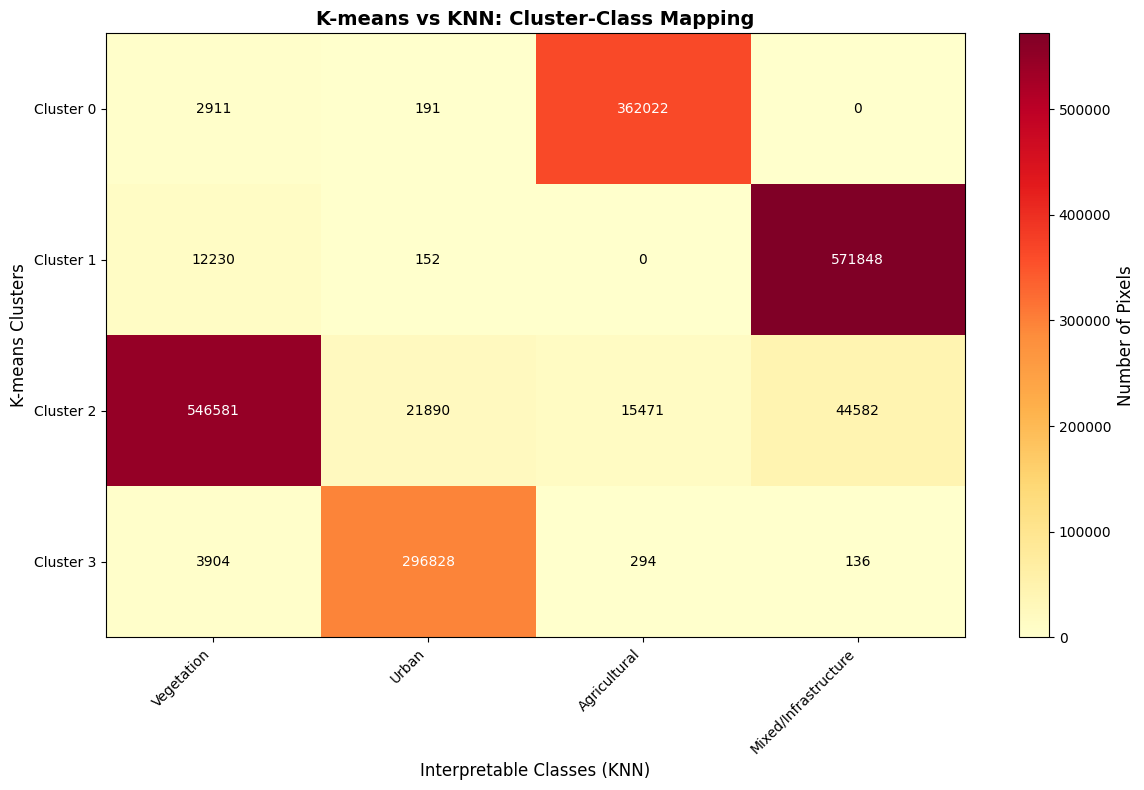

In [28]:
# Visualize cross-tabulation as heatmap
plt.figure(figsize=(12, 8))
im = plt.imshow(crosstab, cmap='YlOrRd', interpolation='nearest', aspect='auto')
cbar = plt.colorbar(im)
cbar.set_label('Number of Pixels', fontsize=12)

# Add text annotations
for i in range(crosstab.shape[0]):
    for j in range(crosstab.shape[1]):
        plt.text(j, i, str(crosstab[i, j]), ha='center', va='center',
                color='white' if crosstab[i, j] > crosstab.max() / 2 else 'black')

plt.xticks(range(len(class_names)), [class_names[i] for i in range(len(class_names))], rotation=45, ha='right')
plt.yticks(range(k), [f'Cluster {i}' for i in range(k)])
plt.xlabel('Interpretable Classes (KNN)', fontsize=12)
plt.ylabel('K-means Clusters', fontsize=12)
plt.title('K-means vs KNN: Cluster-Class Mapping', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 11. Summary and Conclusions

In [29]:
print("="*80)
print("SPARK K-MEANS SCALABILITY STUDY - SUMMARY")
print("="*80)

print(f"\n📊 Dataset:")
print(f"  - Total pixels: {embeddings_array.shape[0]:,}")
print(f"  - Embedding dimension: {embeddings_array.shape[1]}")
print(f"  - Number of tiles: {len(tile_metadata)}")
print(f"  - Geographic region: {bbox}")

print(f"\n🔧 K-means Clustering (Spark):")
print(f"  - Number of clusters: {k}")
print(f"  - Training time: {training_time:.2f} seconds")
print(f"  - WSSSE: {model.summary.trainingCost:.2f}")

print(f"\n📈 Scalability Analysis:")
print(f"  - Dataset sizes tested: {len(sample_sizes)}")
print(f"  - Max data points: {max(data_points):,}")
print(f"  - Time range: {min(training_times):.2f}s - {max(training_times):.2f}s")

print(f"\n🎯 KNN Classification:")
print(f"  - Labeled samples: {n_labeled_samples:,}")
print(f"  - Test accuracy: {accuracy:.2%}")
print(f"  - Number of classes: {len(class_names)}")

print(f"\n🔍 Key Findings:")
print(f"  - K-means successfully scaled to {embeddings_array.shape[0]:,} data points")
print(f"  - Interpretable classes align with unsupervised clusters")
print(f"  - PCA shows clear cluster separation with {sum(pca.explained_variance_ratio_):.1%} variance in 2D")

print("\n" + "="*80)
print("✓ Analysis complete!")
print("="*80)

SPARK K-MEANS SCALABILITY STUDY - SUMMARY

📊 Dataset:
  - Total pixels: 1,879,040
  - Embedding dimension: 128
  - Number of tiles: 2
  - Geographic region: (-1.671467, 42.804532, -1.599112, 42.838276)

🔧 K-means Clustering (Spark):
  - Number of clusters: 4
  - Training time: 33.03 seconds
  - WSSSE: 540932379.80

📈 Scalability Analysis:
  - Dataset sizes tested: 5
  - Max data points: 1,879,040
  - Time range: 17.68s - 30.51s

🎯 KNN Classification:
  - Labeled samples: 8,000
  - Test accuracy: 95.71%
  - Number of classes: 4

🔍 Key Findings:
  - K-means successfully scaled to 1,879,040 data points
  - Interpretable classes align with unsupervised clusters
  - PCA shows clear cluster separation with 41.2% variance in 2D

✓ Analysis complete!


## 12. Cleanup

## 10b. Georeferenced KNN Class Maps

Visualize the KNN interpretable classes on georeferenced maps.

In [30]:
# Create KNN class mosaic
print("Creating KNN interpretable class mosaic...")

# Reconstruct KNN class maps for each tile
knn_tile_maps = []
start_idx = 0

for idx, tile in enumerate(tile_metadata):
    n_pixels = tile['n_pixels']
    
    # Extract KNN labels for this tile
    tile_knn_labels = knn_labels_all[start_idx:start_idx + n_pixels]
    
    # Reshape back to spatial dimensions
    h, w = tile['shape'][0], tile['shape'][1]
    tile_knn_map = tile_knn_labels.reshape(h, w)
    
    knn_tile_maps.append(tile_knn_map)
    
    start_idx += n_pixels

# Initialize KNN mosaic (reuse dimensions from section 7b)
knn_mosaic = np.full((height, width), -1, dtype=np.int32)

# Place each tile in the mosaic
for idx, (tile, knn_map) in enumerate(zip(tile_maps, knn_tile_maps)):
    tile_transform = tile['transform']
    
    # Calculate pixel offset
    tile_min_x = tile_transform.c
    tile_max_y = tile_transform.f
    
    col_offset = int((tile_min_x - min_x) / pixel_size_x)
    row_offset = int((max_y - tile_max_y) / pixel_size_y)
    
    tile_height, tile_width = knn_map.shape
    
    # Place the tile
    knn_mosaic[row_offset:row_offset+tile_height, col_offset:col_offset+tile_width] = knn_map

print(f"✓ KNN class mosaic assembly complete!")

Creating KNN interpretable class mosaic...
✓ KNN class mosaic assembly complete!


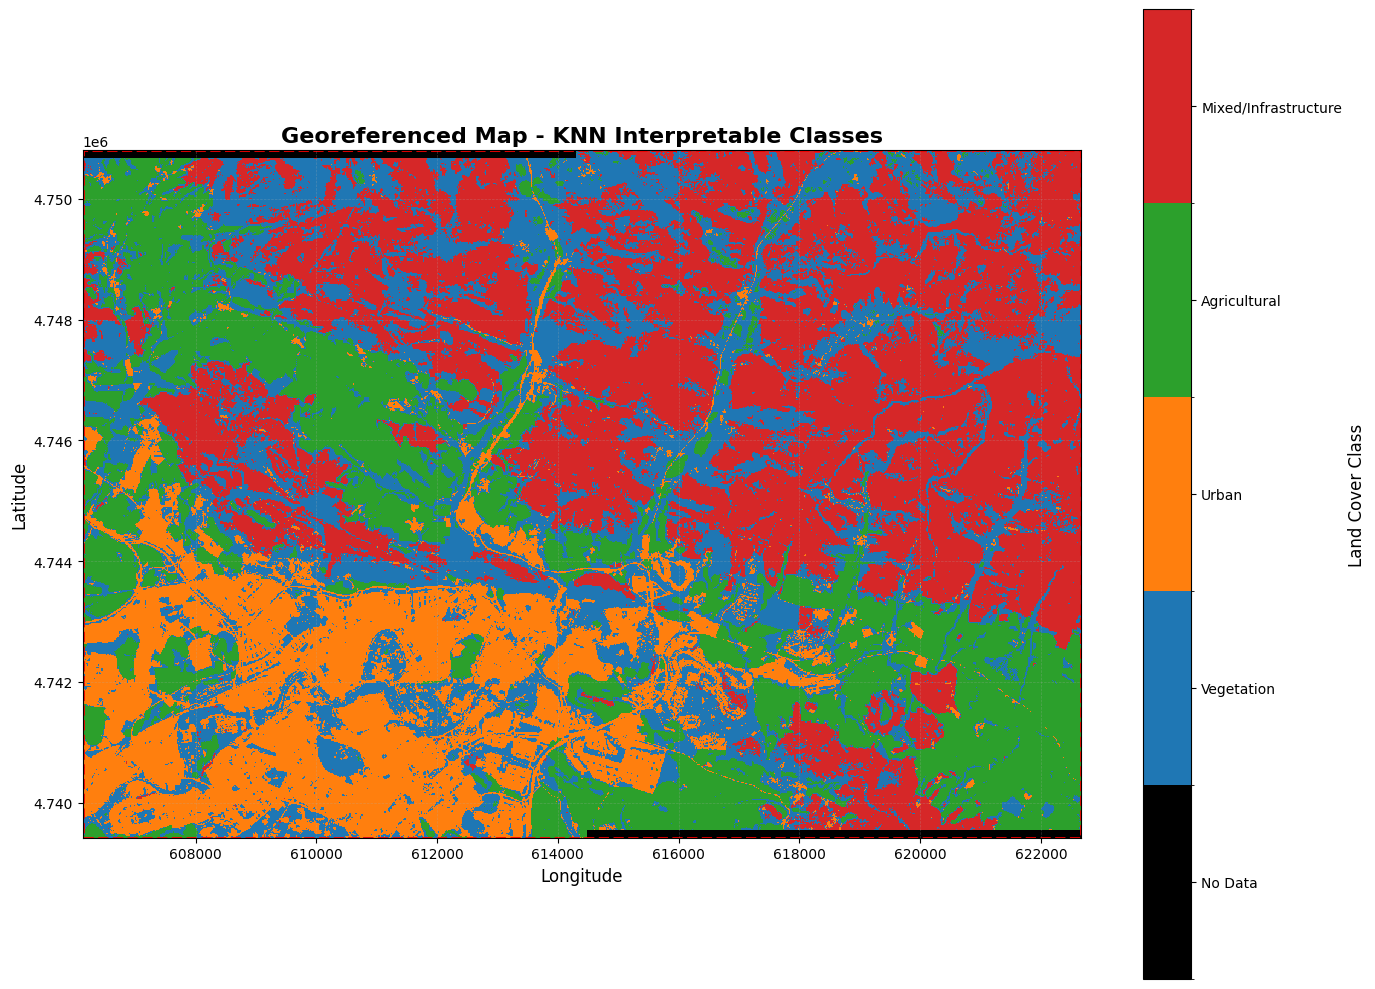

✓ KNN interpretable class map displayed!
CRS: EPSG:32630
Bounding box: (-1.671467, 42.804532, -1.599112, 42.838276)


In [31]:
# Visualize KNN interpretable class mosaic
n_classes = len(class_names)

# Create custom colormap for classes
cmap_classes = plt.cm.tab10.copy()
colors_list_classes = [cmap_classes(i) for i in range(n_classes)]
colors_list_classes.insert(0, (0, 0, 0, 1))  # Black for no-data

custom_cmap_classes = mcolors.ListedColormap(colors_list_classes)
bounds_classes = list(range(-1, n_classes + 1))
norm_classes = mcolors.BoundaryNorm(bounds_classes, custom_cmap_classes.N)

# Plot
fig, ax = plt.subplots(figsize=(14, 10))

im = ax.imshow(knn_mosaic, cmap=custom_cmap_classes, norm=norm_classes, 
               interpolation='nearest', extent=[min_x, max_x, min_y, max_y])

ax.set_title(f'Georeferenced Map - KNN Interpretable Classes', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Colorbar with class names
cbar = plt.colorbar(im, ax=ax, ticks=np.arange(-0.5, n_classes, 1))
cbar.set_label('Land Cover Class', fontsize=12)
cbar.ax.set_yticklabels(['No Data'] + [class_names[i] for i in range(n_classes)])

# Grid and bbox outline
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

rect = Rectangle((min_x, min_y), max_x - min_x, max_y - min_y,
                 linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
ax.add_patch(rect)

plt.tight_layout()
plt.show()

print(f"✓ KNN interpretable class map displayed!")
print(f"CRS: {tile_maps[0]['crs']}")
print(f"Bounding box: {bbox}")

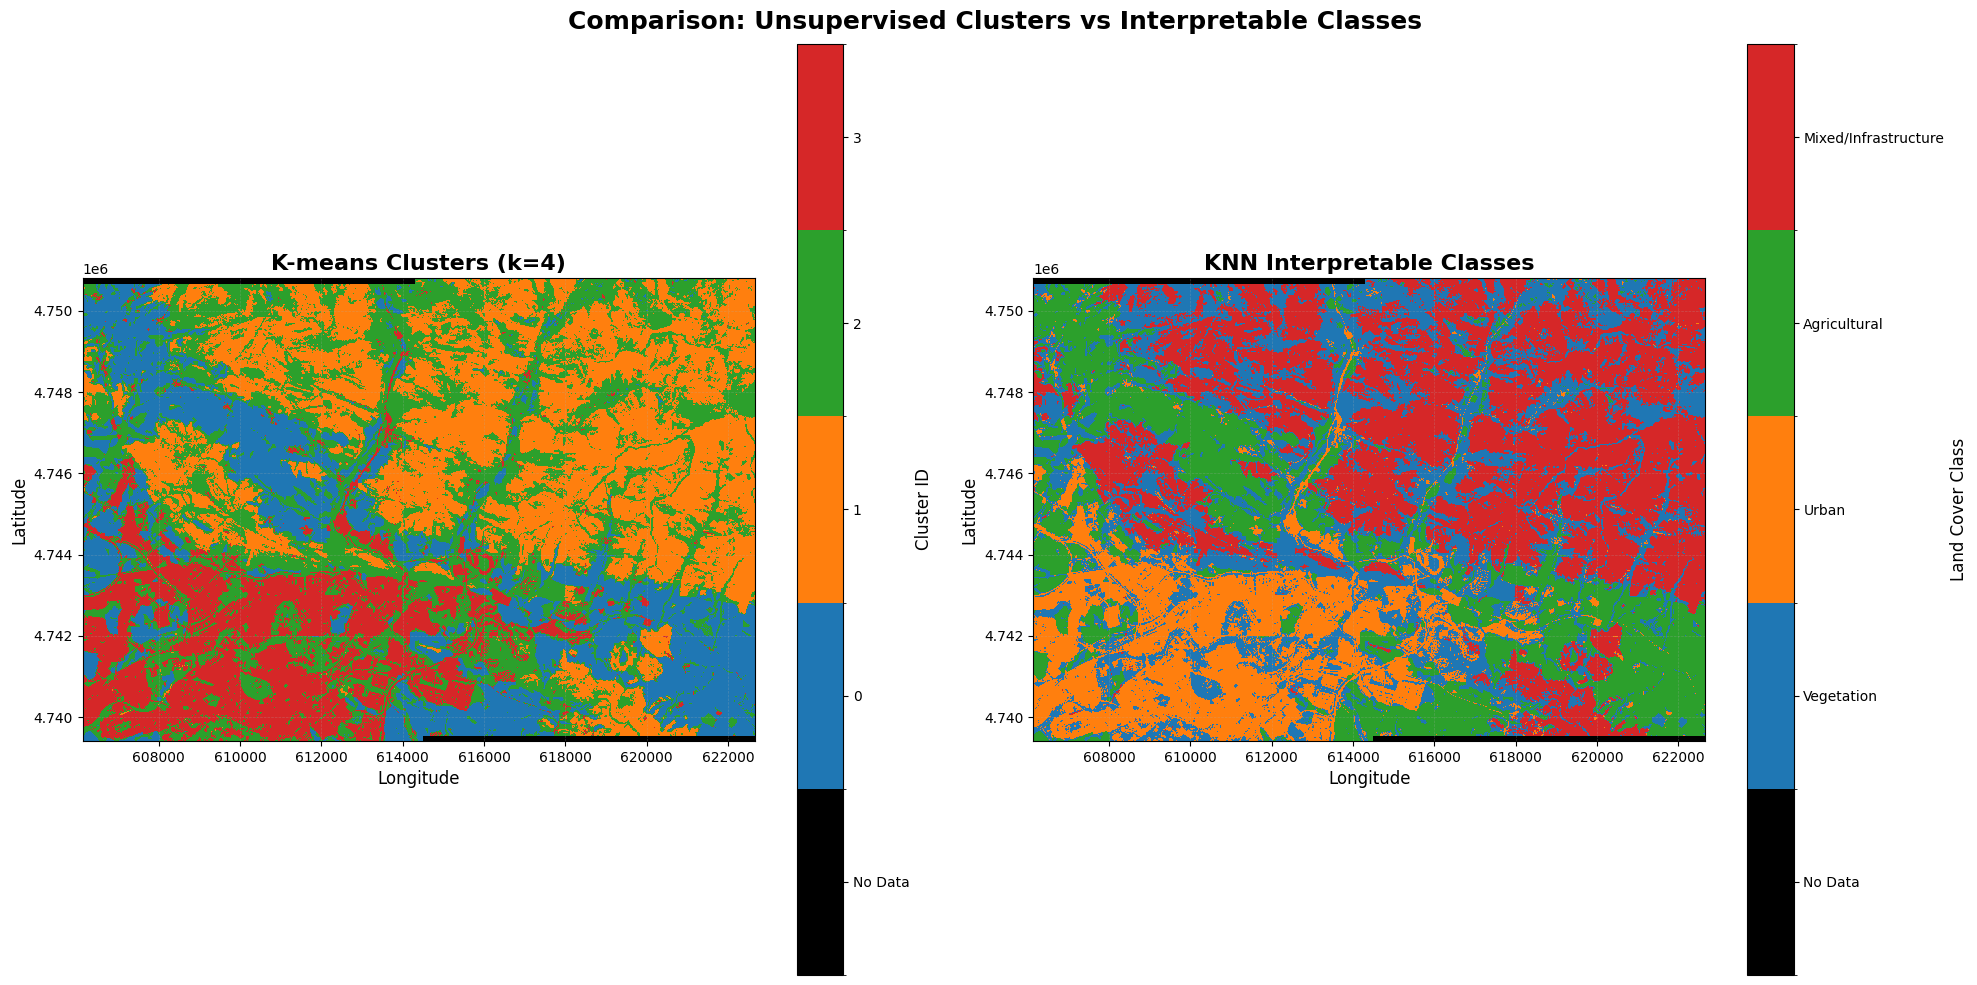


✓ Side-by-side comparison displayed!
Geographic coordinates: (-1.671467, 42.804532, -1.599112, 42.838276)
This visualization shows how unsupervised K-means clusters map to interpretable land cover classes


In [32]:
# Side-by-side comparison of K-means clusters vs KNN classes
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Left: K-means clusters
im1 = axes[0].imshow(cluster_mosaic, cmap=custom_cmap, norm=norm, 
                     interpolation='nearest', extent=[min_x, max_x, min_y, max_y])
axes[0].set_title(f'K-means Clusters (k={k})', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Longitude', fontsize=12)
axes[0].set_ylabel('Latitude', fontsize=12)
axes[0].grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

cbar1 = plt.colorbar(im1, ax=axes[0], ticks=np.arange(-0.5, k, 1))
cbar1.set_label('Cluster ID', fontsize=12)
cbar1.ax.set_yticklabels(['No Data'] + [str(i) for i in range(k)])

# Right: KNN interpretable classes
im2 = axes[1].imshow(knn_mosaic, cmap=custom_cmap_classes, norm=norm_classes,
                     interpolation='nearest', extent=[min_x, max_x, min_y, max_y])
axes[1].set_title(f'KNN Interpretable Classes', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Longitude', fontsize=12)
axes[1].set_ylabel('Latitude', fontsize=12)
axes[1].grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

cbar2 = plt.colorbar(im2, ax=axes[1], ticks=np.arange(-0.5, n_classes, 1))
cbar2.set_label('Land Cover Class', fontsize=12)
cbar2.ax.set_yticklabels(['No Data'] + [class_names[i] for i in range(n_classes)])

plt.suptitle('Comparison: Unsupervised Clusters vs Interpretable Classes', 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print(f"\n✓ Side-by-side comparison displayed!")
print(f"Geographic coordinates: {bbox}")
print(f"This visualization shows how unsupervised K-means clusters map to interpretable land cover classes")

## 10c. Export Clustering Results to GeoTIFF

Save the georeferenced cluster and class maps as GeoTIFF files for use in GIS software.

In [33]:
import rasterio
from rasterio.crs import CRS

# Define output file paths
kmeans_tiff_path = "kmeans_clusters.tif"
knn_tiff_path = "knn_classes.tif"

# Get CRS from tile metadata
tile_crs = tile_maps[0]['crs']

print(f"Saving clustering results to GeoTIFF...")
print(f"Output CRS: {tile_crs}")
print(f"Bounding box: ({min_x:.6f}, {min_y:.6f}, {max_x:.6f}, {max_y:.6f})")
print(f"Mosaic dimensions: {height} x {width} pixels")

# Save K-means cluster mosaic
print(f"\nWriting K-means clusters to {kmeans_tiff_path}...")
with rasterio.open(
    kmeans_tiff_path,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=rasterio.int32,
    crs=tile_crs,
    transform=output_transform,
    nodata=-1
) as dst:
    dst.write(cluster_mosaic, 1)
    dst.set_band_description(1, 'K-means Cluster ID')

print(f"✓ Saved K-means clusters: {kmeans_tiff_path}")

# Save KNN interpretable class mosaic
print(f"\nWriting KNN classes to {knn_tiff_path}...")
with rasterio.open(
    knn_tiff_path,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=rasterio.int32,
    crs=tile_crs,
    transform=output_transform,
    nodata=-1
) as dst:
    dst.write(knn_mosaic, 1)
    dst.set_band_description(1, 'Land Cover Class')

print(f"✓ Saved KNN classes: {knn_tiff_path}")

# Display file information
import os
print(f"\n{'='*60}")
print(f"GeoTIFF Export Summary:")
print(f"{'='*60}")
print(f"\nK-means Clusters:")
print(f"  File: {kmeans_tiff_path}")
print(f"  Size: {os.path.getsize(kmeans_tiff_path) / 1024:.2f} KB")
print(f"  Values: -1 (no data), 0-{k-1} (cluster IDs)")

print(f"\nKNN Interpretable Classes:")
print(f"  File: {knn_tiff_path}")
print(f"  Size: {os.path.getsize(knn_tiff_path) / 1024:.2f} KB")
print(f"  Values: -1 (no data), 0-{n_classes-1} (class IDs)")
print(f"  Classes: {', '.join([class_names[i] for i in range(n_classes)])}")

print(f"\n✓ GeoTIFF files ready for use in GIS software (QGIS, ArcGIS, etc.)")
print(f"{'='*60}")

Saving clustering results to GeoTIFF...
Output CRS: EPSG:32630
Bounding box: (606133.215021, 4739420.725289, 622657.426022, 4750801.402397)
Mosaic dimensions: 1138 x 1652 pixels

Writing K-means clusters to kmeans_clusters.tif...
✓ Saved K-means clusters: kmeans_clusters.tif

Writing KNN classes to knn_classes.tif...
✓ Saved KNN classes: knn_classes.tif

GeoTIFF Export Summary:

K-means Clusters:
  File: kmeans_clusters.tif
  Size: 7357.83 KB
  Values: -1 (no data), 0-3 (cluster IDs)

KNN Interpretable Classes:
  File: knn_classes.tif
  Size: 7357.83 KB
  Values: -1 (no data), 0-3 (class IDs)
  Classes: Vegetation, Urban, Agricultural, Mixed/Infrastructure

✓ GeoTIFF files ready for use in GIS software (QGIS, ArcGIS, etc.)


In [34]:
# Stop Spark session
# spark.stop()
# print("✓ Spark session stopped")